In [23]:
import argparse
import logging
import socket
import sys
import time
import random
import os
import pickle
import torch
import numpy as np
from sys import exit
from collections import defaultdict, namedtuple
import itertools
import json
import math
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import matplotlib.pyplot as plt
import copy
import socialforce
import pykalman
from socialforce.field_of_view import FieldOfView
from socialforce.potentials import PedPedPotential
from scipy.interpolate import interp1d

In [24]:
from trajnetplusplustools import TrackRow, SceneRow, Reader

In [25]:
def prepare_data(path, subset='/train/', sample=1.0, goals=True):
    """ Prepares the train/val scenes and corresponding goals 
    
    Parameters
    ----------
    subset: String ['/train/', '/val/']
        Determines the subset of data to be processed
    sample: Float (0.0, 1.0]
        Determines the ratio of data to be sampled
    goals: Bool
        If true, the goals of each track are extracted
        The corresponding goal file must be present in the 'goal_files' folder
        The name of the goal file must be the same as the name of the training file

    Returns
    -------
    all_scenes: List
        List of all processed scenes
    all_goals: Dictionary
        Dictionary of goals corresponding to each dataset file.
        None if 'goals' argument is False.
    Flag: Bool
        True if the corresponding folder exists else False.
    """

    ## Check if folder exists
    if not os.path.isdir(path + subset):
        if 'train' in subset:
            print("Train folder does NOT exist")
            exit()
        if 'val' in subset:
            print("Validation folder does NOT exist")
            return None, None, False

    ## read goal files
    all_goals = {}
    all_scenes = []

    ## List file names
    # files = [f.split('.')[-2] for f in os.listdir(path + subset) if f.endswith('.ndjson')]
    files = [os.path.splitext(os.path.basename(f))[0] for f in os.listdir(path + subset) if f.endswith('.ndjson')]
    #此处应该考虑每个文件的scaler不同。需要把scaler一起读出来。
    ## Iterate over file names
    for file in files:
        reader = Reader(path + subset + file + '.ndjson', scene_type='paths')
        ## Necessary modification of train scene to add filename
        scene = [(file, s_id, s) for s_id, s in reader.scenes(sample=sample)]
        if goals:
            goal_dict = pickle.load(open('goal_files/' + subset + file +'.pkl', "rb"))
            ## Get goals corresponding to train scene
            all_goals[file] = {s_id: [goal_dict[path[0].pedestrian] for path in s] for _, s_id, s in scene}
        all_scenes += scene

    if goals:
        return all_scenes, all_goals, True
    return all_scenes, None, True


In [26]:
def main(epochs=100):
    parser = argparse.ArgumentParser()
    parser.add_argument('--epochs', default=epochs, type=int,
                        help='number of epochs')
    parser.add_argument('--save_every', default=5, type=int,
                        help='frequency of saving model (in terms of epochs)')
    parser.add_argument('--obs_length', default=25, type=int,
                        help='observation length')
    parser.add_argument('--pred_length', default=25, type=int,
                        help='prediction length')
    parser.add_argument('--start_length', default=0, type=int,
                        help='starting time step of encoding observation')
    parser.add_argument('--batch_size', default=8, type=int)
    parser.add_argument('--lr', default=1e-3, type=float,
                        help='initial learning rate')
    parser.add_argument('--step_size', default=10, type=int,
                        help='step_size of lr scheduler')
    parser.add_argument('-o', '--output', default=None,
                        help='output file')
    parser.add_argument('--disable-cuda', action='store_true',
                        help='disable CUDA')
    parser.add_argument('--path', default='trajdata',
                        help='glob expression for data files')
    parser.add_argument('--goals', action='store_true',
                        help='flag to consider goals of pedestrians')
    parser.add_argument('--loss', default='pred', choices=('L2', 'pred'),
                        help='loss objective, L2 loss (L2) and Gaussian loss (pred)')
    parser.add_argument('--type', default='vanilla',
                        choices=('vanilla', 'occupancy', 'directional', 'social', 'hiddenstatemlp',
                                 'nn', 'attentionmlp', 'nn_lstm', 'traj_pool'),
                        help='type of interaction encoder')
    parser.add_argument('--sample', default=1.0, type=float,
                        help='sample ratio when loading train/val scenes')
    parser.add_argument('--seed', type=int, default=42)

    # Augmentations
    parser.add_argument('--augment', action='store_true',
                        help='perform rotation augmentation')
    parser.add_argument('--normalize_scene', action='store_true',
                        help='rotate scene so primary pedestrian moves northwards at end of observation')
    parser.add_argument('--augment_noise', action='store_true',
                        help='flag to add noise to observations for robustness')
    parser.add_argument('--obs_dropout', action='store_true',
                        help='perform observation length dropout')

    # Loading pre-trained models
    pretrain = parser.add_argument_group('pretraining')
    pretrain.add_argument('--load-state', default=None,
                          help='load a pickled model state dictionary before training')
    pretrain.add_argument('--load-full-state', default=None,
                          help='load a pickled full state dictionary before training')
    pretrain.add_argument('--nonstrict-load-state', default=None,
                          help='load a pickled state dictionary before training')

    # Sequence Encoder Hyperparameters
    hyperparameters = parser.add_argument_group('hyperparameters')
    hyperparameters.add_argument('--hidden-dim', type=int, default=128,
                                 help='LSTM hidden dimension')
    hyperparameters.add_argument('--coordinate-embedding-dim', type=int, default=64,
                                 help='coordinate embedding dimension')
    hyperparameters.add_argument('--pool_dim', type=int, default=256,
                                 help='output dimension of interaction vector')
    hyperparameters.add_argument('--goal_dim', type=int, default=64,
                                 help='goal embedding dimension')

    # Grid-based pooling
    hyperparameters.add_argument('--cell_side', type=float, default=0.6,
                                 help='cell size of real world (in m) for grid-based pooling')
    hyperparameters.add_argument('--n', type=int, default=12,
                                 help='number of cells per side for grid-based pooling')
    hyperparameters.add_argument('--layer_dims', type=int, nargs='*', default=[512],
                                 help='interaction module layer dims for gridbased pooling')
    hyperparameters.add_argument('--embedding_arch', default='one_layer',
                                 help='interaction encoding arch for gridbased pooling')
    hyperparameters.add_argument('--pool_constant', default=0, type=int,
                                 help='background value (when cell empty) of gridbased pooling')
    hyperparameters.add_argument('--norm_pool', action='store_true',
                                 help='normalize the scene along direction of movement during grid-based pooling')
    hyperparameters.add_argument('--front', action='store_true',
                                 help='flag to only consider pedestrian in front during grid-based pooling')
    hyperparameters.add_argument('--latent_dim', type=int, default=16,
                                 help='latent dimension of encoding hidden dimension during social pooling')
    hyperparameters.add_argument('--norm', default=0, type=int,
                                 help='normalization scheme for input batch during grid-based pooling')

    # Non-Grid-based pooling
    hyperparameters.add_argument('--no_vel', action='store_true',
                                 help='flag to not consider relative velocity of neighbours')
    hyperparameters.add_argument('--spatial_dim', type=int, default=32,
                                 help='embedding dimension for relative position')
    hyperparameters.add_argument('--vel_dim', type=int, default=32,
                                 help='embedding dimension for relative velocity')
    hyperparameters.add_argument('--neigh', default=4, type=int,
                                 help='number of nearest neighbours to consider')
    hyperparameters.add_argument('--mp_iters', default=5, type=int,
                                 help='message passing iterations in NMMP')

    # Collision Loss
    hyperparameters.add_argument('--col_wt', default=0., type=float,
                                 help='collision loss weight')
    hyperparameters.add_argument('--col_distance', default=0.2, type=float,
                                 help='distance threshold post which collision occurs')
    args = parser.parse_args()

    # Set seed for reproducibility
    torch.manual_seed(args.seed)
    random.seed(args.seed)

    # Define location to save trained model
    if not os.path.exists('OUTPUT_BLOCK/{}'.format(args.path)):
        os.makedirs('OUTPUT_BLOCK/{}'.format(args.path))
    if args.goals:
        args.output = 'OUTPUT_BLOCK/{}/lstm_goals_{}_{}.pkl'.format(args.path, args.type, args.output)
    else:
        args.output = 'OUTPUT_BLOCK/{}/lstm_{}_{}.pkl'.format(args.path, args.type, args.output)

    # configure logging
    if args.load_full_state:
        file_handler = logging.FileHandler(args.output + '.log', mode='a')
    else:
        file_handler = logging.FileHandler(args.output + '.log', mode='w')
    file_handler.setFormatter(jsonlogger.JsonFormatter('%(message)s %(levelname)s %(name)s %(asctime)s'))
    stdout_handler = logging.StreamHandler(sys.stdout)
    logging.basicConfig(level=logging.INFO, handlers=[stdout_handler, file_handler])
    logging.info({
        'type': 'process',
        'argv': sys.argv,
        'args': vars(args),
        'version': version,
        'hostname': socket.gethostname(),
    })

    # refactor args for --load-state
    # loading a previously saved model
    args.load_state_strict = True
    if args.nonstrict_load_state:
        args.load_state = args.nonstrict_load_state
        args.load_state_strict = False
    if args.load_full_state:
        args.load_state = args.load_full_state

    # add args.device
    args.device = torch.device('cpu')
    if not args.disable_cuda and torch.cuda.is_available():
        args.device = torch.device('cuda')

    args.path = 'DATA_BLOCK/' + args.path
    # Prepare data
    train_scenes, train_goals, _ = prepare_data(args.path, subset='/train/', sample=args.sample, goals=args.goals)
    val_scenes, val_goals, val_flag = prepare_data(args.path, subset='/val/', sample=args.sample, goals=args.goals)

    # pretrained pool model (if any)
    pretrained_pool = None

    # # create interaction/pooling modules
    # pool = None
    # if args.type == 'hiddenstatemlp':
    #     pool = HiddenStateMLPPooling(hidden_dim=args.hidden_dim, out_dim=args.pool_dim,
    #                                  mlp_dim_vel=args.vel_dim)
    # elif args.type == 'attentionmlp':
    #     pool = AttentionMLPPooling(hidden_dim=args.hidden_dim, out_dim=args.pool_dim,
    #                                mlp_dim_spatial=args.spatial_dim, mlp_dim_vel=args.vel_dim)
    # elif args.type == 'nn':
    #     pool = NearestNeighborMLP(n=args.neigh, out_dim=args.pool_dim, no_vel=args.no_vel)
    # elif args.type == 'nn_lstm':
    #     pool = NearestNeighborLSTM(n=args.neigh, hidden_dim=args.hidden_dim, out_dim=args.pool_dim)
    # elif args.type == 'traj_pool':
    #     pool = TrajectronPooling(hidden_dim=args.hidden_dim, out_dim=args.pool_dim)
    # elif args.type != 'vanilla':
    #     pool = GridBasedPooling(type_=args.type, hidden_dim=args.hidden_dim,
    #                             cell_side=args.cell_side, n=args.n, front=args.front,
    #                             out_dim=args.pool_dim, embedding_arch=args.embedding_arch,
    #                             constant=args.pool_constant, pretrained_pool_encoder=pretrained_pool,
    #                             norm=args.norm, layer_dims=args.layer_dims, latent_dim=args.latent_dim)
    # hyper parameters
    input_size = 8  # frame, car_id, x, y, xVelocity, yVelocity, dx, dy, dvx, dvy
    hidden_size = 8  # LSTM hidden size
    num_layers = 1  # LSTM layers
    output_size = 2  # ax, ay as output

    # create forecasting model
    model = MyModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size,
                    device= args.device)

    # optimizer and schedular
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-3)
    lr_scheduler = None
    if args.step_size is not None:
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, args.step_size)
    start_epoch = 0

    # # Loss Criterion
    # criterion = L2Loss(col_wt=args.col_wt, col_distance=args.col_distance) if args.loss == 'L2' \
    #                 else PredictionLoss(col_wt=args.col_wt, col_distance=args.col_distance)
    #
    criterion = torch.nn.MSELoss()

    # train
    if args.load_state:
        # load pretrained model.
        # useful for transfer learning
        print("Loading Model Dict")
        with open(args.load_state, 'rb') as f:
            checkpoint = torch.load(f)
        pretrained_state_dict = checkpoint['state_dict']
        model.load_state_dict(pretrained_state_dict, strict=args.load_state_strict)

        if args.load_full_state:
            # load optimizers from last training
            # useful to continue model training
            print("Loading Optimizer Dict")
            optimizer.load_state_dict(checkpoint['optimizer'])
            lr_scheduler.load_state_dict(checkpoint['scheduler'])
            start_epoch = checkpoint['epoch']

    # trainer
    trainer = Trainer(model, optimizer=optimizer, lr_scheduler=lr_scheduler, device=args.device,
                      criterion=criterion, batch_size=args.batch_size, obs_length=args.obs_length,
                      pred_length=args.pred_length, augment=args.augment, normalize_scene=args.normalize_scene,
                      save_every=args.save_every, start_length=args.start_length, obs_dropout=args.obs_dropout,
                      augment_noise=args.augment_noise, val_flag=val_flag)
    trainer.loop(train_scenes, val_scenes, train_goals, val_goals, args.output, epochs=args.epochs, start_epoch=start_epoch)

In [27]:

def drop_distant(xyv, r=10):
    """
    Drops pedestrians more than r meters away from primary ped
    """
    distance_2 = np.sum(np.square(xyv[:, :, :2] - xyv[:, 0:1, :2]), axis=2)
    mask = np.nanmin(distance_2, axis=0) < r ** 2
    return xyv[:, mask], mask


def rotate_path(path, theta):
    ct = math.cos(theta)
    st = math.sin(theta)

    return [TrackRow(r.frame, r.car_id, ct * r.x + st * r.y, -st * r.x + ct * r.y,
                     ct*r.xVelocity + st * r.yVelocity, -st * r.xVelocity + ct * r.yVelocity
                     ) for r in path]


def random_rotation_of_paths(paths):
    theta = random.random() * 2.0 * math.pi
    return [rotate_path(path, theta) for path in paths]


def random_rotation(xyv, goals=None):
    theta = random.random() * 2.0 * math.pi
    ct = math.cos(theta)
    st = math.sin(theta)
    r = np.array([[ct, st], [-st, ct]])

    # 旋转位置
    rotated_positions = np.einsum('ptc,ci->pti', xyv[:, :, :2], r)

    # 旋转速度
    rotated_velocities = np.einsum('ptc,ci->pti', xyv[:, :, 2:], r)

    # 合并旋转后的位置和速度
    rotated_xyv = np.concatenate((rotated_positions, rotated_velocities), axis=2)

    if goals is None:
        return rotated_xyv
    else:
        # 如果提供了goals，则旋转goals（假设它们也是[x, y, xVelocity, yVelocity]格式的）
        rotated_goals_pos = np.einsum('tc,ci->ti', goals[:, :2], r)
        rotated_goals_vel = np.einsum('tc,ci->ti', goals[:, 2:], r)
        rotated_goals = np.concatenate((rotated_goals_pos, rotated_goals_vel), axis=1)
        return rotated_xyv, rotated_goals


def theta_rotation(xyv, theta):
    ct = math.cos(theta)
    st = math.sin(theta)
    r = np.array([[ct, st], [-st, ct]])

    # 旋转位置
    rotated_positions = np.einsum('ptc,ci->pti', xyv[:, :, :2], r)

    # 旋转速度
    rotated_velocities = np.einsum('ptc,ci->pti', xyv[:, :, 2:], r)

    # 合并旋转后的位置和速度
    rotated_xyv = np.concatenate((rotated_positions, rotated_velocities), axis=2)

    return rotated_xyv


def shift(xyv, center):
    # theta = random.random() * 2.0 * math.pi
    xyv = xyv - center[np.newaxis, np.newaxis, :]
    return xyv


def center_scene(xyv, obs_length=9, car_id=0, goals=None):
    if goals is not None:
        goals = goals[np.newaxis, :, :]
    # Center
    center = xyv[obs_length-1, car_id]  # Last Observation
    xyv = shift(xyv, center)
    if goals is not None:
        goals = shift(goals, center)
    # Rotate
    last_obs = xyv[obs_length-1, car_id]
    second_last_obs = xyv[obs_length-2, car_id]
    diff = np.array([last_obs[0] - second_last_obs[0], last_obs[1] - second_last_obs[1],
                        last_obs[2] - second_last_obs[2], last_obs[3] - second_last_obs[3]])
    theta = np.arctan2(diff[1], diff[0])
    rotation = -theta + np.pi/2
    xyv = theta_rotation(xyv, rotation)
    if goals is not None:
        goals = theta_rotation(goals, rotation)
        return xyv, rotation, center, goals[0]
    return xyv, rotation, center


def inverse_scene(xyv, rotation, center):
    xyv = theta_rotation(xyv, -rotation)
    xyv = shift(xyv, -center)
    return xyv


def drop_unobserved(xyv, obs_length=25):
    loc_at_obs = xyv[obs_length-1]
    absent_at_obs = np.isnan(loc_at_obs).any(axis=1)
    mask = ~absent_at_obs
    return xyv[:, mask], mask


def neigh_nan(xyv):
    return np.isnan(xyv).all()


def add_noise(observation, thresh=0.005, obs_length=25, ped='primary'):
    if ped == 'primary':
        observation[:obs_length, 0] += np.random.uniform(-thresh, thresh, observation[:obs_length, 0].shape)
    elif ped == 'neigh':
        observation[:obs_length, 1:] += np.random.uniform(-thresh, thresh, observation[:obs_length, 1:].shape)
    else:
        raise ValueError

    return observation


In [28]:

class InputEmbedding(torch.nn.Module):
    """Linear embedding, ReLU non-linearity, input scaling.

    Input scaling is important for ReLU activation combined with the initial
    bias distribution. Otherwise some units will never be active.
    """
    def __init__(self, input_dim, embedding_dim, scale, use_tags=True):
        super(InputEmbedding, self).__init__()
        self.embedding_dim = embedding_dim
        self.scale = scale
        self.use_tags = use_tags

        linear_embedding_dim = self.embedding_dim
        if use_tags:
            linear_embedding_dim -= 2
        self.input_embeddings = torch.nn.Sequential(
            torch.nn.Linear(input_dim, linear_embedding_dim),
            torch.nn.ReLU(),
        )

    def forward(self, vel):
        if self.use_tags:
            return torch.cat([
                self.input_embeddings(vel * self.scale),
                torch.zeros(vel.size(0), 2, device=vel.device),
            ], dim=1)
        return self.input_embeddings(vel * self.scale)

    def start_enc(self, vel):
        """Create a start tag with an appropriate shape and device for vel."""
        if not self.use_tags:
            raise Exception('Input embedding does not support start tag')

        v = torch.zeros(vel.size(0), self.embedding_dim, device=vel.device)
        v[:, -2] = 1
        return v

    def start_dec(self, vel):
        """Create a start tag with an appropriate shape and device for vel."""
        if not self.use_tags:
            raise Exception('Input embedding does not support start tag')

        v = torch.zeros(vel.size(0), self.embedding_dim, device=vel.device)
        v[:, -1] = 1
        return v


class Hidden2Normal(torch.nn.Module):
    def __init__(self, hidden_dim):
        super(Hidden2Normal, self).__init__()
        self.linear = torch.nn.Linear(hidden_dim, 5)

    def forward(self, hidden_state):
        normal = self.linear(hidden_state)

        # numerically stable output ranges
        normal[:, 2] = 0.01 + 0.2 * torch.sigmoid(normal[:, 2])  # sigma 1
        normal[:, 3] = 0.01 + 0.2 * torch.sigmoid(normal[:, 3])  # sigma 2
        normal[:, 4] = 0.7 * torch.sigmoid(normal[:, 4])  # rho

        return normal


In [29]:
NAN = float('nan')

def drop_distant(xy, r=6.0):
    """
    Drops pedestrians more than r meters away from primary ped
    """
    distance_2 = np.sum(np.square(xy - xy[:, 0:1]), axis=2)
    mask = np.nanmin(distance_2, axis=0) < r**2
    return xy[:, mask], mask


def generate_pooling_inputs(obs2, obs1, hidden_cell_state, track_mask, batch_split):
    hidden_states_to_pool = torch.stack(hidden_cell_state[0]).clone() # detach?
    hidden_dim = hidden_states_to_pool.size(-1)
    # tensor for pooling; filled with nan-mask [bs, max # neighbor, 2]
    max_num_neighbor = (batch_split[1:] - batch_split[:-1]).max()   # number of agents in a scene minus the primary
    batch_size = len(batch_split) - 1
    curr_positions = torch.empty(batch_size, max_num_neighbor, 2).fill_(float('nan')).to(obs1.device) # placeholder
    prev_positions = torch.empty(batch_size, max_num_neighbor, 2).fill_(float('nan')).to(obs1.device) # placeholder
    curr_hidden_state = torch.empty(batch_size, max_num_neighbor, hidden_dim).fill_(float('nan')).to(obs1.device) # placeholder
    track_mask_positions = torch.empty(batch_size, max_num_neighbor).fill_(False).bool().to(obs1.device)  # placeholder

    for i in range(batch_size):
        curr_positions[i, :batch_split[i+1]-batch_split[i]] = obs2[batch_split[i]:batch_split[i+1]]
        prev_positions[i, :batch_split[i+1]-batch_split[i]] = obs1[batch_split[i]:batch_split[i+1]]
        curr_hidden_state[i, :batch_split[i+1]-batch_split[i]] = hidden_states_to_pool[batch_split[i]:batch_split[i+1]]
        track_mask_positions[i, :batch_split[i+1]-batch_split[i]] = track_mask[batch_split[i]:batch_split[i+1]].bool()

    return curr_positions, prev_positions, curr_hidden_state, track_mask_positions

In [30]:
class LSTM(torch.nn.Module):
    def __init__(self, embedding_dim=64, hidden_dim=128, pool=None, pool_to_input=True, goal_dim=None, goal_flag=False):
        """ Initialize the LSTM forecasting model

        Attributes
        ----------
        embedding_dim : Embedding dimension of location coordinates
        hidden_dim : Dimension of hidden state of LSTM
        pool : interaction module
        pool_to_input : Bool
            if True, the interaction vector is concatenated to the input embedding of LSTM [preferred]
            if False, the interaction vector is added to the LSTM hidden-state
        goal_dim : Embedding dimension of the unit vector pointing towards the goal
        goal_flag: Bool
            if True, the embedded goal vector is concatenated to the input embedding of LSTM 
        """

        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.pool = pool
        self.pool_to_input = pool_to_input

        ## Location
        scale = 4.0
        self.input_embedding = InputEmbedding(2, self.embedding_dim, scale)

        ## Goal
        self.goal_flag = goal_flag
        self.goal_dim = goal_dim or embedding_dim
        self.goal_embedding = InputEmbedding(2, self.goal_dim, scale)
        goal_rep_dim = self.goal_dim if self.goal_flag else 0

        ## Pooling
        pooling_dim = 0
        if pool is not None and self.pool_to_input:
            pooling_dim = self.pool.out_dim 
        
        ## LSTMs
        self.encoder = torch.nn.LSTMCell(self.embedding_dim + goal_rep_dim + pooling_dim, self.hidden_dim)
        self.decoder = torch.nn.LSTMCell(self.embedding_dim + goal_rep_dim + pooling_dim, self.hidden_dim)

        # Predict the parameters of a multivariate normal:
        # mu_vel_x, mu_vel_y, sigma_vel_x, sigma_vel_y, rho
        self.hidden2normal = Hidden2Normal(self.hidden_dim)


    def step(self, lstm, hidden_cell_state, obs1, obs2, goals, batch_split):
        """Do one step of prediction: two inputs to one normal prediction.
        
        Parameters
        ----------
        lstm: torch nn module [Encoder / Decoder]
            The module responsible for prediction
        hidden_cell_state : tuple (hidden_state, cell_state)
            Current hidden_cell_state of the pedestrians
        obs1 : Tensor [num_tracks, 2]
            Previous x-y positions of the pedestrians
        obs2 : Tensor [num_tracks, 2]
            Current x-y positions of the pedestrians
        goals : Tensor [num_tracks, 2]
            Goal coordinates of the pedestrians
        
        Returns
        -------
        hidden_cell_state : tuple (hidden_state, cell_state)
            Updated hidden_cell_state of the pedestrians
        normals : Tensor [num_tracks, 5]
            Parameters of a multivariate normal of the predicted position 
            with respect to the current position
        """
        num_tracks = len(obs2)
        # mask for pedestrians absent from scene (partial trajectories)
        # consider only the hidden states of pedestrains present in scene
        track_mask = (torch.isnan(obs1[:, 0]) + torch.isnan(obs2[:, 0])) == 0



        ## Masked Hidden Cell State
        hidden_cell_stacked = [
            torch.stack([h for m, h in zip(track_mask, hidden_cell_state[0]) if m], dim=0),
            torch.stack([c for m, c in zip(track_mask, hidden_cell_state[1]) if m], dim=0),
        ]

        ## Mask current velocity & embed
        curr_velocity = obs2 - obs1
        curr_velocity = curr_velocity[track_mask]
        input_emb = self.input_embedding(curr_velocity)

        ## Mask Goal direction & embed
        if self.goal_flag:
            ## Get relative direction to goals (wrt current position)
            norm_factors = (torch.norm(obs2 - goals, dim=1))
            goal_direction = (obs2 - goals) / norm_factors.unsqueeze(1)
            goal_direction[norm_factors == 0] = torch.tensor([0., 0.], device=obs1.device)
            goal_direction = goal_direction[track_mask]
            goal_emb = self.goal_embedding(goal_direction)
            input_emb = torch.cat([input_emb, goal_emb], dim=1)

        ## Mask & Pool per scene
        if self.pool is not None:
            curr_positions, prev_positions, curr_hidden_state, track_mask_positions = \
                generate_pooling_inputs(obs2, obs1, hidden_cell_state, track_mask, batch_split)
            pool_sample = self.pool(curr_hidden_state, prev_positions, curr_positions)
            pooled = pool_sample[track_mask_positions.view(-1)]

            if self.pool_to_input:
                input_emb = torch.cat([input_emb, pooled], dim=1)
            else:
                hidden_cell_stacked[0] += pooled

        # LSTM step
        hidden_cell_stacked = lstm(input_emb, hidden_cell_stacked)
        normal_masked = self.hidden2normal(hidden_cell_stacked[0])

        # unmask [Update hidden-states and next velocities of pedestrians]
        normal = torch.full((track_mask.size(0), 5), NAN, device=obs1.device)
        mask_index = [i for i, m in enumerate(track_mask) if m]
        for i, h, c, n in zip(mask_index,
                              hidden_cell_stacked[0],
                              hidden_cell_stacked[1],
                              normal_masked):
            hidden_cell_state[0][i] = h
            hidden_cell_state[1][i] = c
            normal[i] = n

        return hidden_cell_state, normal

    def forward(self, observed, goals, batch_split, prediction_truth=None, n_predict=None):
        """Forecast the entire sequence 
        
        Parameters
        ----------
        observed : Tensor [obs_length, num_tracks, 2]
            Observed sequences of x-y coordinates of the pedestrians
        goals : Tensor [num_tracks, 2]
            Goal coordinates of the pedestrians
        batch_split : Tensor [batch_size + 1]
            Tensor defining the split of the batch.
            Required to identify the tracks of to the same scene        
        prediction_truth : Tensor [pred_length - 1, num_tracks, 2]
            Prediction sequences of x-y coordinates of the pedestrians
            Helps in teacher forcing wrt neighbours positions during training
        n_predict: Int
            Length of sequence to be predicted during test time

        Returns
        -------
        rel_pred_scene : Tensor [pred_length, num_tracks, 5]
            Predicted velocities of pedestrians as multivariate normal
            i.e. positions relative to previous positions
        pred_scene : Tensor [pred_length, num_tracks, 2]
            Predicted positions of pedestrians i.e. absolute positions
        """

        assert ((prediction_truth is None) + (n_predict is None)) == 1
        if n_predict is not None:
            # -1 because one prediction is done by the encoder already
            prediction_truth = [None for _ in range(n_predict - 1)]

        # initialize: Because of tracks with different lengths and the masked
        # update, the hidden state for every LSTM needs to be a separate object
        # in the backprop graph. Therefore: list of hidden states instead of
        # a single higher rank Tensor.
        num_tracks = observed.size(1)
        hidden_cell_state = (
            [torch.zeros(self.hidden_dim, device=observed.device) for _ in range(num_tracks)],
            [torch.zeros(self.hidden_dim, device=observed.device) for _ in range(num_tracks)],
        )

        ## Reset LSTMs of Interaction Encoders.
        if self.pool is not None:
            max_num_neighbor = (batch_split[1:] - batch_split[:-1]).max() - 1
            batch_size = len(batch_split) - 1
            self.pool.reset(batch_size * (max_num_neighbor+1), max_num_neighbor, device=observed.device)

        # list of predictions
        normals = []  # predicted normal parameters for both phases
        positions = []  # true (during obs phase) and predicted positions

        if len(observed) == 2:
            positions = [observed[-1]]

        # encoder
        for obs1, obs2 in zip(observed[:-1], observed[1:]):
            ##LSTM Step
            hidden_cell_state, normal = self.step(self.encoder, hidden_cell_state, obs1, obs2, goals, batch_split)

            # concat predictions
            normals.append(normal)
            positions.append(obs2 + normal[:, :2])  # no sampling, just mean

        # initialize predictions with last position to form velocity. DEEP COPY !!!
        prediction_truth = copy.deepcopy(list(itertools.chain.from_iterable(
            (observed[-1:], prediction_truth)
        )))

        # decoder, predictions
        for obs1, obs2 in zip(prediction_truth[:-1], prediction_truth[1:]):

            if obs1 is None:
                obs1 = positions[-2].detach()  # DETACH!!!
            else:
                for primary_id in batch_split[:-1]:
                    obs1[primary_id] = positions[-2][primary_id].detach()  # DETACH!!!
            if obs2 is None:
                obs2 = positions[-1].detach()
            else:
                for primary_id in batch_split[:-1]:
                    obs2[primary_id] = positions[-1][primary_id].detach()  # DETACH!!!

            hidden_cell_state, normal = self.step(self.decoder, hidden_cell_state, obs1, obs2, goals, batch_split)

            # concat predictions
            normals.append(normal)
            positions.append(obs2 + normal[:, :2])  # no sampling, just mean

        # Pred_scene: Tensor [seq_length, num_tracks, 2]
        #    Absolute positions of all pedestrians
        # Rel_pred_scene: Tensor [seq_length, num_tracks, 5]
        #    Velocities of all pedestrians
        rel_pred_scene = torch.stack(normals, dim=0)
        pred_scene = torch.stack(positions, dim=0)

        return rel_pred_scene, pred_scene

In [31]:
class MyModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, device, scale_factors=None):
        super(MyModel, self).__init__()
        self.l1 = nn.Linear(input_size, output_size)  # Linear layer
        self.tanh = nn.Tanh()
        self.l2 = nn.Linear(output_size, output_size)
        self.lstm = nn.LSTM(output_size, hidden_size, num_layers)  # LSTM layer
        self.reset_parameters()
        self.scale_factors = scale_factors \
            if scale_factors is not None else \
                torch.tensor([2, 0.5, 0.01, 0.02]).to(device) # scaler for ind
        self.device = device


#                 torch.tensor([2, 0.5, 0.01, 0.02]).to(device) # scaler for ind
#                 torch.tensor([4.0, 0.3, 0.5, 0.015]).to(device) #scaler for highd
    def reset_parameters(self):
        # Reset parameters for linear and LSTM layers
        self.l1.reset_parameters()
        self.l2.reset_parameters()
        self.lstm.reset_parameters()

    def encoder(self, input_seq, lengths):
        fx_fy = self.l1(input_seq)
        fx_fy = self.tanh(fx_fy)
        fx_fy = self.l2(fx_fy)

        # Sort the sequences by length in descending order
        lengths, indices = lengths.sort(descending=True)
        fx_fy = fx_fy[:, indices]

        # Pack the sequences
        fx_fy_packed = pack_padded_sequence(fx_fy, lengths.cpu(), enforce_sorted=False)

        # Get the outputs from the LSTM
        # _, (acc, _) = self.lstm(fx_fy_packed)
        output, _ = self.lstm(fx_fy_packed)
        output_padded, _ = pad_packed_sequence(output, batch_first=True)
        acc = output_padded[:, -1]

        # Reshape the output
        acc = acc.squeeze(0)

        # Restore the original order
        _, inv_indices = indices.sort()
        acc = acc[inv_indices]

        return - acc# minus or positive

    def decoder(self, last_positions, acc_tensor):
        fps = 25
        dt = 1 / fps  # Time step

        # Extract x, y, x_velocity, y_velocity from the last positions
        x, y, x_velocity, y_velocity = torch.chunk(last_positions, 4, dim=-1)

        # Compute predicted velocities
        x_velocity_pred = x_velocity + dt * acc_tensor[:, 0].unsqueeze(1)
        y_velocity_pred = y_velocity + dt * acc_tensor[:, 1].unsqueeze(1)

        # Compute predicted positions
        x_pred = x + dt * x_velocity_pred
        y_pred = y + dt * y_velocity_pred

        # Combine the predicted positions and velocities
        pred_frame = torch.cat([x_pred, y_pred, x_velocity_pred, y_velocity_pred], dim=-1)

        return pred_frame

    def forward(self, observed, prediction_truth, batch_split):

        # Unscale the observed data
        unscaled_observed = observed * self.scale_factors.unsqueeze(0).unsqueeze(0)

        # get all nan lines indices
        mask = torch.isnan(unscaled_observed[:, :, 0])
        nan_rows = mask.all(dim=0)
        indices_to_keep = torch.where(~nan_rows)[0]

        # Delete the all nan lines
        unscaled_observed = torch.index_select(unscaled_observed, 1, indices_to_keep)
        prediction_truth = torch.index_select(prediction_truth, 1, indices_to_keep)

        # Update the batch_split
        nan_indices = torch.nonzero(nan_rows).squeeze()
        for i in range(1, len(batch_split)):
            subtract_count = (nan_indices < batch_split[i]).sum().item()
            batch_split[i] -= subtract_count

        # Mask the observed data
        mask = torch.isnan(unscaled_observed[:, :, 0])
        unscaled_observed = torch.where(torch.isnan(unscaled_observed), torch.zeros_like(unscaled_observed),
                                        unscaled_observed)
        lengths = (~mask).sum(dim=0).cpu().long()
        pooled_positions = self.generate_pooling(unscaled_observed, batch_split)

        # Get each batch's primary_car for truth without loop
        primary_indices = batch_split[:-1]
        target_truth = prediction_truth[:, primary_indices].to(self.device)
        target_pred = torch.zeros_like(target_truth).to(self.device)
        pred_frames = target_truth.shape[0]
        pred_full = torch.zeros_like(prediction_truth).to(self.device)
        acc = torch.zeros_like(target_truth[:, :, :2]).to(self.device)
        for i in range(pred_frames):
            last_positions = pooled_positions[-1, :, :4]

            acc_tensor = self.encoder(pooled_positions, lengths)

            # Decode the acc_tensor to get the predicted positions and velocities for the current frame
            pred_frame = self.decoder(last_positions, acc_tensor)

            # Scale the predictions
            scaled_prediction = pred_frame / self.scale_factors.unsqueeze(0)

            # Store the prediction 应该是此frame对应的batch数量行，因为是primary cars。列数是4.
            target_pred[i] = scaled_prediction[primary_indices]

            # Generate pooling for the predicted frame
            pooled_pred_frame = self.generate_pooling(pred_frame, batch_split)

            # Add the new pooled_pred_frame to the end of pooled_positions and remove the first frame
            pooled_positions = torch.cat([pooled_positions[1:], pooled_pred_frame.unsqueeze(0)], dim=0)
            
            # generate full prediciton to make the visualization possible
            pred_full[i] = scaled_prediction
            
            acc[i] = acc_tensor[primary_indices]
        truth_full = prediction_truth
            

        return target_pred, target_truth, pred_full, truth_full, acc

#     def generate_pooling(self, obs_data, batch_split):
#         single_frame = False

#         # Check if it's a single frame data
#         if len(obs_data.shape) == 2:
#             single_frame = True
#             obs_data = obs_data.unsqueeze(0)  # Add a frame dimension

#         num_frames, num_cars, _ = obs_data.shape
#         curr_positions = obs_data.clone()  # Clone obs_data to get curr_positions

#         # Create a mask where cars with all zeros are considered missing
#         valid_cars = (obs_data.sum(dim=2) != 0).unsqueeze(2)

#         # Expand dimensions to allow broadcasting
#         expanded_obs = obs_data.unsqueeze(2)
#         expanded_valid_cars = valid_cars.unsqueeze(2)

#         # Calculate the differences using broadcasting
#         diffs = expanded_obs - obs_data.unsqueeze(1)

#         # Use the valid cars mask to ignore calculations involving missing cars
#         diffs *= expanded_valid_cars
# #         non_zero = (diffs.all(dim=2) != 0)

#         # Sum the differences along the car axis
#         rel_positions = diffs.sum(dim=2)

#         # Concatenate along the third dimension
#         pooled_positions = torch.cat((curr_positions, rel_positions), dim=2)

#         # Remove the added frame dimension if it's a single frame data
#         if single_frame:
#             pooled_positions = pooled_positions.squeeze(0)

#         return pooled_positions

    def generate_pooling(self, obs_data, batch_split):
        single_frame = False

        # Check if it's a single frame data
        if len(obs_data.shape) == 2:
            single_frame = True
            obs_data = obs_data.unsqueeze(0)  # Add a frame dimension

        num_frames, num_cars, _ = obs_data.shape
        curr_positions = obs_data.clone()  # Clone obs_data to get curr_positions

        # Create a mask where cars with all zeros are considered missing
        valid_cars = (obs_data.sum(dim=2) != 0).unsqueeze(2)

        # Expand dimensions to allow broadcasting
        expanded_obs = obs_data.unsqueeze(2)
        expanded_valid_cars = valid_cars.unsqueeze(2)

        # Calculate the differences using broadcasting
        diffs = expanded_obs - obs_data.unsqueeze(1)

        eps = 1e-10
        diffs[diffs == 0] += eps  # Add a very small value to zero entries

        # Calculate the inverse
        diffs_inv = 1.0 / diffs

        # Set values that are extremely large (because of the division by a small value) to zero
        threshold = 1e9  # You can adjust this threshold as needed
        diffs_inv[diffs_inv.abs() > threshold] = 0

        # Use the valid cars mask to ignore calculations involving missing cars
        diffs_inv *= expanded_valid_cars

        # Sum the inversed differences along the car axis
        scores = diffs_inv.sum(dim=2)

        # Concatenate along the third dimension
        pooled_positions = torch.cat((curr_positions, scores), dim=2)

        # Remove the added frame dimension if it's a single frame data
        if single_frame:
            pooled_positions = pooled_positions.squeeze(0)

        return pooled_positions



class LSTMPredictor(object):
    def __init__(self, model):
        self.model = model

    def save(self, state, filename):
        with open(filename, 'wb') as f:
            torch.save(self, f)

        # # during development, good for compatibility across API changes:
        # # Save state for optimizer to continue training in future
        with open(filename + '.state', 'wb') as f:
            torch.save(state, f)

    @staticmethod
    def load(filename):
        with open(filename, 'rb') as f:
            return torch.load(f)

    def __call__(self, paths, scene_goal, n_predict=12, modes=1, predict_all=True, obs_length=25, start_length=0,
                 args=None):
        self.model.eval()
        # self.model.train()
        with torch.no_grad():
            xyv = Reader.paths_to_xyv(paths)
            # xyv = add_noise(xyv, thresh=args.thresh, ped=args.ped_type)
            batch_split = [0, xyv.shape[1]]

            if args.normalize_scene:
                xyv, rotation, center, scene_goal = center_scene(xyv, obs_length, goals=scene_goal)

            xyv = torch.Tensor(xyv)  # .to(self.device)
            scene_goal = torch.Tensor(scene_goal)  # .to(device)
            batch_split = torch.Tensor(batch_split).long()

            multimodal_outputs = {}
            for num_p in range(modes):
                # _, output_scenes = self.model(xyv[start_length:obs_length], scene_goal, batch_split, xyv[obs_length:-1].clone())
                _, output_scenes = self.model(xyv[start_length:obs_length], scene_goal, batch_split, n_predict=n_predict)
                output_scenes = output_scenes.numpy()
                if args.normalize_scene:
                    output_scenes = inverse_scene(output_scenes, rotation, center)
                output_primary = output_scenes[-n_predict:, 0]
                output_neighs = output_scenes[-n_predict:, 1:]
                ## Dictionary of predictions. Each key corresponds to one mode
                multimodal_outputs[num_p] = [output_primary, output_neighs]

        ## Return Dictionary of predictions. Each key corresponds to one mode
        return multimodal_outputs

In [32]:
def final_l2(path1, path2):
    row1 = path1[-1]
    row2 = path2[-1]
    return np.linalg.norm((row2.x - row1.x, row2.y - row1.y))


def average_l2(path1, path2, n_predictions=25):
    assert len(path1) >= n_predictions
    assert len(path2) >= n_predictions
    path1 = path1[-n_predictions:]
    path2 = path2[-n_predictions:]

    return sum(np.linalg.norm((r1.x - r2.x, r1.y - r2.y))
               for r1, r2 in zip(path1, path2)) / n_predictions

In [33]:
def predict_kf(paths, predict_all=True, n_predict=25, obs_length=25):
    multimodal_outputs = {}
    neighbours_tracks = []

    primary = paths[0]
    start_frame = primary[obs_length-1].frame
    frame_diff = primary[1].frame - primary[0].frame
    first_frame = start_frame + frame_diff

    ## Primary Prediction
    if not predict_all:
        paths = paths[0:1]

    for i, path in enumerate(paths):
        path = paths[i]
        ped_id = path[0].car_id
        past_path = [t for t in path if t.frame <= start_frame]
        past_frames = [t.frame for t in path if t.frame <= start_frame]

        ## To consider agent or not consider.
        if start_frame not in past_frames:
            continue
        if len(past_path) < 2:
            continue

        initial_state_mean = [path[0].x, 0, path[0].y, 0]
        transition_matrix = [[1, 1, 0, 0],
                             [0, 1, 0, 0],
                             [0, 0, 1, 1],
                             [0, 0, 0, 1]]

        observation_matrix = [[1, 0, 0, 0],
                              [0, 0, 1, 0]]

        kf = pykalman.KalmanFilter(transition_matrices=transition_matrix,
                                   observation_matrices=observation_matrix,
                                   transition_covariance=1e-5 * np.eye(4),
                                   observation_covariance=0.05**2 * np.eye(2),
                                   initial_state_mean=initial_state_mean)
        # kf.em([(r.x, r.y) for r in path[:9]], em_vars=['transition_matrices',
        #                                                'observation_matrices'])
        kf.em([(r.x, r.y) for r in past_path])
        observed_states, _ = kf.smooth([(r.x, r.y) for r in past_path])


        # sample predictions (first sample corresponds to last state)
        # average 5 sampled predictions
        predictions = None
        for _ in range(5):
            _, pred = kf.sample(n_predict + 1, initial_state=observed_states[-1])
            if predictions is None:
                predictions = pred
            else:
                predictions += pred
        predictions /= 5.0

        #write
        if i == 0:
            primary_track = predictions[1:]
        else:
            neighbours_tracks.append(np.array(predictions[1:]))

    ## Unimodal Ouput
    if len(np.array(neighbours_tracks)):
        neighbours_tracks = np.array(neighbours_tracks).transpose(1, 0, 2)

    multimodal_outputs[0] = primary_track, neighbours_tracks
    return multimodal_outputs


In [34]:
def predict_sf(input_paths, dest_dict=None, dest_type='interp', sf_params=[0.5, 2.1, 0.3],
            predict_all=True, n_predict=25, obs_length=25):
    
    pred_length = n_predict

    def init_states(input_paths, start_frame, dest_dict, dest_type):
        initial_state = []
        for i, _ in enumerate(input_paths):
            path = input_paths[i]
            ped_id = path[0].car_id
            past_path = [t for t in path if t.frame <= start_frame]
            past_frames = [t.frame for t in path if t.frame <= start_frame]
            future_path = [t for t in path if t.frame > start_frame]
            len_path = len(past_path)

            ## To consider agent or not consider.
            if start_frame in past_frames:
                curr = past_path[-1]

                ## Velocity
                if len_path >= 4:
                    stride = 3
                    prev = past_path[-4]
                else:
                    stride = len_path - 1
                    prev = past_path[-len_path]
                [v_x, v_y] = vel_state(prev, curr, stride)

                ## Destination
                if dest_type == 'true':
                    if dest_dict is not None:
                        [d_x, d_y] = dest_dict[ped_id]
                    else:
                        raise ValueError
                elif dest_type == 'interp':
                    [d_x, d_y] = dest_state(past_path, len_path)
                elif dest_type == 'vel':
                    [d_x, d_y] = [pred_length*v_x, pred_length*v_y]
                elif dest_type == 'pred_end':
                    [d_x, d_y] = [future_path[-1].x, future_path[-1].y]
                else:
                    raise NotImplementedError

                ## Initialize State
                initial_state.append([curr.x, curr.y, v_x, v_y, d_x, d_y])
        return np.array(initial_state)

    def vel_state(prev, curr, stride):
        if stride == 0:
            return [0, 0]
        diff = np.array([curr.x - prev.x, curr.y - prev.y])
        theta = np.arctan2(diff[1], diff[0])
        speed = np.linalg.norm(diff) / (stride * 0.4)
        return [speed*np.cos(theta), speed*np.sin(theta)]

    def dest_state(path, length):
        if length == 1:
            return [path[-1].x, path[-1].y]
        x = [t.x for t in path]
        y = [t.y for t in path]
        time = list(range(length))
        f = interp1d(x=time, y=[x, y], fill_value='extrapolate')
        return f(time[-1] + pred_length)

    multimodal_outputs = {}
    primary = input_paths[0]
    neighbours_tracks = []
    frame_diff = primary[1].frame - primary[0].frame
    start_frame = primary[obs_length-1].frame
    first_frame = primary[obs_length-1].frame + frame_diff

    # initialize
    initial_state = init_states(input_paths, start_frame, dest_dict, dest_type)

    fps = 25
    sampling_rate = int(fps / 1)

#     if len(initial_state) != 0:
#         # run  
#         ped_ped = PedPedPotential(v0=sf_params[1], sigma=sf_params[2])
#         field_of_view = FieldOfView()
#         s = socialforce.Simulator(ped_ped=ped_ped, field_of_view=field_of_view,
#                                   delta_t=1./fps, tau=sf_params[0])
#         states = np.stack([s.step().state.copy() for _ in range(pred_length*sampling_rate)])
#         ## states : pred_length x num_ped x 7
#         states = np.array([s for num, s in enumerate(states) if num % sampling_rate == 0])
        
        
    if len(initial_state) != 0:
        # 准备参数和模拟器
        ped_ped = PedPedPotential(v0=sf_params[1], sigma=sf_params[2])
        field_of_view = FieldOfView()
        s = socialforce.Simulator(ped_ped=ped_ped, field_of_view=field_of_view, 
                                  delta_t=1./fps, tau=sf_params[0])

        # 确保initial_state是正确的数据类型和格式
        initial_state = torch.tensor(initial_state, dtype=torch.float32)  # 以您的实际initial_state来修改

        # 执行模拟
        number_of_steps = pred_length * sampling_rate  # 根据您的需求修改
        result_states = s.run(initial_state, number_of_steps)

        # 如果您需要的states是numpy array类型，您可以这样转换：
        states = result_states.detach().numpy()

        # 您可以根据需要处理和过滤模拟的结果
        states = np.array([s for num, s in enumerate(states) if num % sampling_rate == 0])

    else:
        ## Stationary
        past_path = [t for t in input_paths[0] if t.frame == start_frame]
        states = np.stack([[[past_path[0].x, past_path[0].y]] for _ in range(pred_length)])

    # predictions
    primary_track = states[:, 0, 0:2]
    neighbours_tracks = states[:, 1:, 0:2]

    ## Primary Prediction Only
    if not predict_all:
        neighbours_tracks = []

    # Unimodal Prediction
    multimodal_outputs[0] = primary_track, neighbours_tracks
    return multimodal_outputs

In [35]:
class Evaluator(object):
    def __init__(self, scenes, dest_dict=None, params=None, args=None):
        self.scenes = scenes
        self.dest = dest_dict
        self.params = params

        self.average_l2 = {'N': len(scenes)}
        self.final_l2 = {'N': len(scenes)}

        self.args = args

    def aggregate(self, name, predictor, dest_type='true'):
        print('evaluating', name)

        average = 0.0
        final = 0.0

        # pred_dict = {}
        # pred_neigh_dict = {}
        # n = 0

        for _, paths in enumerate(self.scenes):
            ## select only those trajectories which interactions ##
            # rows = trajnetplusplustools.Reader.paths_to_xy(paths)
            # neigh_paths = paths[1:]
            # interaction_index = collision_avoidance(rows)
            # neigh = list(compress(neigh_paths, interaction_index))
            # paths = [paths[0]] + neigh

            if 'kf' in name:
                prediction, neigh = predictor(paths, n_predict=self.args.pred_length, obs_length=self.args.obs_length)[0]
            if 'sf' in name:
                prediction, neigh = predictor(paths, self.dest, dest_type, self.params['sf'])[0]
            # if 'orca' in name:
            #     prediction, neigh = predictor(paths, self.dest, dest_type, self.params['orca'], args=self.args)[0]

            ## visualize predictions ##
            # pred_dict['pred'] = prediction
            # pred_neigh_dict['pred'] = neigh
            # n += 1
            # if n < 17:
            #     with show.predicted_paths(paths, pred_dict, pred_neigh_paths=pred_neigh_dict):
            #         pass
            # else:
            #     break

            ## Convert numpy array to Track Rows ##
            ## Extract 1) first_frame, 2) frame_diff 3) ped_ids for writing predictions
            observed_path = paths[0]
            frame_diff = observed_path[1].frame - observed_path[0].frame
            first_frame = observed_path[self.args.obs_length-1].frame + frame_diff
            ped_id = observed_path[0].car_id

            ## make Track Rows
            prediction = [TrackRow(first_frame + i * frame_diff, ped_id, prediction[i, 0], prediction[i, 1], 0)
                          for i in range(len(prediction))]

            average_l2_a = average_l2(paths[0], prediction)
            final_l2_a = final_l2(paths[0], prediction)
            print(average_l2_a)

            # aggregate
            average += average_l2_a
            final += final_l2_a

        average /= len(self.scenes)
        final /= len(self.scenes)

        self.average_l2[name] = average
        self.final_l2[name] = final

        return self

    def result(self):
        return self.average_l2, self.final_l2

In [36]:
def eval(input_file, dest_file, simulator, params, type_ids, args):
    print('dataset', input_file)

    reader = Reader(input_file, scene_type='paths')
    scenes = [s for _, s in reader.scenes()]

    dest_dict = None
    if dest_file is not None:
        dest_dict = pickle.load(open(dest_file, "rb"))

    evaluator = Evaluator(scenes, dest_dict, params, args)
    
    
    ## Evaluate all
    if simulator == 'all':
        for dest_type in ['interp']:
            # evaluator.aggregate('orca' + dest_type, orca.predict, dest_type)
            evaluator.aggregate('sf' + dest_type, predict_sf, dest_type)
            evaluator.aggregate('kf', predict_kf)

    # Social Force only
    elif simulator == 'sf':
        for dest_type in ['interp']:
            evaluator.aggregate('sf' + dest_type, predict_sf, dest_type)

    # Kalman only
    elif simulator == 'kf':  
        evaluator.aggregate('kf', predict_kf)

    return evaluator.result()

In [37]:
class Args:
    obs_length = 25
    pred_length = 25
    simulator = 'sf'
    tau = 0.5
    vo = 2.1
    sigma = 0.3
    min_dist = 4
    react_time = 4
    radius = 0.6

args = Args()


In [38]:
def main1(args):
    params = {}
    if args.simulator == 'sf' or 'all':
        params['sf'] = [args.tau, args.vo, args.sigma]
    # if args.simulator == 'orca' or 'all':
    #     params['orca'] = [args.min_dist, args.react_time, args.radius]

    print(params)
    datasets = [
        'DATA_BLOCK/ind/test/04_tracks.ndjson'
    ]
    print(datasets)

    dest_dicts = None

    filtered_ids = {}


    results = {}
    for i, dataset in enumerate(datasets):
        type_ids = None
        dataset_name = dataset.replace('DATA_BLOCK/ind/test/', '').replace('.ndjson', '')
        if dataset_name in filtered_ids:
            type_ids = filtered_ids[dataset_name]       
        results[dataset_name] = eval(dataset, dest_dicts, args.simulator, params, type_ids, args)

    if args.simulator == 'all':
        print('## Average L2 [m]')
        print('{dataset:>30s} | N | SF | KF '.format(dataset=''))
        print(results)
        for dataset, (r, _) in results.items():
            print(
                '{dataset:>30s}'
                ' | {r[N]:>4}'
                ' | {r[orcainterp]:.2f}'
                ' | {r[sfinterp]:.2f}'
                ' | {r[kf]:.2f}'.format(dataset=dataset, r=r)
            )
        print('')

        print('## Final L2 [m]')
        print('{dataset:>30s} | N | SF | KF '.format(dataset=''))
        for dataset, (_, r) in results.items():
            print(
                '{dataset:>30s}'
                ' | {r[N]:>4}'
                ' | {r[orcainterp]:.2f}'
                ' | {r[sfinterp]:.2f}'
                ' | {r[kf]:.2f}'.format(dataset=dataset, r=r)
            )

In [39]:
def Traj_plot_classical(scene_index, scenes, simulator, criterion):
    if simulator == 'sf':
        prediction, neigh = predict_sf(scenes[scene_index], None, 'interp', params['sf'])[0]
    elif simulator == 'kf':
        prediction, neigh = predict_kf(scenes[scene_index], n_predict=25, obs_length=25)[0]
    else:
        for simulator in ['sf', 'kf']:
            Traj_plot_classical(scene_index, scenes, simulator, criterion)
        return 0
    train_scale=np.array([2, 0.5, 0.01, 0.02])
    xy = np.array([[row.x, row.y] for row in scenes[scene_index][2]])
    
    train_scale = train_scale[:2]
    
    observed = xy[:25]
    truth = xy[25:50]
    
    
    # Calculate the loss
    observed_path = scenes[scene_index][2]
    frame_diff = observed_path[1].frame - observed_path[0].frame
    first_frame = observed_path[24].frame + frame_diff
    ped_id = observed_path[0].car_id

    ## make Track Rows
    prediction_list = [TrackRow(first_frame + i * frame_diff, ped_id, prediction[i, 0], prediction[i, 1], 0)
                  for i in range(len(prediction))]

    train_loss = criterion(scenes[scene_index][0], prediction_list)
#     train_loss = torch.tensor(0)
    # Convert to numpy for plotting
    observed_np = (observed * train_scale)
    pred_np = (prediction * train_scale)
    print(pred_np)
    truth_np = (truth * train_scale)
    
#     pred_full_np = (pred_full * train_scale.unsqueeze(0).unsqueeze(0)).cpu().numpy()
#     truth_full_np = (truth_full * train_scale.unsqueeze(0).unsqueeze(0)).cpu().numpy()

    # Plotting
    plt.figure(figsize=(12, 8))
    plt.plot(observed_np[:, 0], observed_np[:, 1], 'b--', linewidth=2, label='Traj_observed')
    plt.scatter(observed_np[:, 0], observed_np[:, 1], c='b', s=5)
    
    plt.plot(pred_np[:, 0], pred_np[:, 1], 'g-', label='Traj_pred')
    plt.scatter(pred_np[:, 0], pred_np[:, 1], c='g', s=5)

    plt.plot(truth_np[:, 0], truth_np[:, 1], 'r-', label='Traj_target')
    plt.scatter(truth_np[:, 0], truth_np[:, 1], c='r', s=5)

    plt.scatter(observed_np[-1, 0], observed_np[-1, 1], marker='^', s=100, c='black', label='Current State')
    train_loss = train_loss.item()
    plt.text(0.95, 0.01, f'simulator:{simulator}\n'f'Loss: {train_loss:.4f}', verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes)

    
    plt.axis('equal') 
    plt.legend()
    plt.savefig('Traj_plot.png')
    plt.show()



In [40]:
params = {}
params['sf'] = [args.tau, args.vo, args.sigma]

In [25]:
train_scenes, train_goals, _ = prepare_data(path='DATA_BLOCK/try1' , subset='/train/', sample=1, goals=0)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_4372\3754005529.py:45: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  scene_ids = random.sample(scene_ids, int(len(scene_ids) * sample))


In [35]:
## Initialize batch of scenes
batch_size = 10
batch_scene = []
batch_split = [0]

for scene_i, (filename, scene_id, paths) in enumerate(train_scenes):
    ## make new scene
    scene = Reader.paths_to_xyv(paths)

    #scene: frame_index x car_index x xyv
    ## Augment scene to batch of scenes
    batch_scene.append(scene)
    batch_split.append(int(scene.shape[1]))

    if ((scene_i + 1) % batch_size == 0) or ((scene_i + 1) == len(train_scenes)):
        ## Construct Batch torch.Size([50, 317, 4])
        batch_scene = np.concatenate(batch_scene, axis=1)
        batch_split = np.cumsum(batch_split)
        batch_scene = torch.Tensor(batch_scene).to(device)
        batch_split = torch.Tensor(batch_split).to(device).long()
        observed = batch_scene[0:25].clone()
        prediction_truth = batch_scene[25:50].clone()
        # 25frames x 10primary cars x [x, y, xV, yV]
        print(observed[:, :, :2])
        break
        train_pred, train_truth = model(observed, prediction_truth, batch_split)
        print('train_pred:\n',train_pred,train_pred.shape)
        print('train_truth:\n',train_truth,train_truth.shape)
        loss = criterion(train_pred, train_truth)
        print('loss:\n', loss)
        break
        ## Reset Batch
        batch_scene = []
        batch_scene_goal = []
        batch_split = [0]


tensor([[[17.3350, 29.7667],
         [13.1275, 14.3667],
         [88.3550, 97.5667],
         ...,
         [    nan,     nan],
         [    nan,     nan],
         [    nan,     nan]],

        [[17.0300, 29.7333],
         [12.9100, 14.4000],
         [88.5875, 97.6000],
         ...,
         [    nan,     nan],
         [    nan,     nan],
         [    nan,     nan]],

        [[16.7225, 29.6667],
         [12.6975, 14.4000],
         [88.8225, 97.6000],
         ...,
         [    nan,     nan],
         [    nan,     nan],
         [    nan,     nan]],

        ...,

        [[10.6100, 28.9000],
         [ 8.3125, 14.6667],
         [93.4475, 98.0333],
         ...,
         [ 2.2700, 70.7000],
         [    nan,     nan],
         [    nan,     nan]],

        [[10.3075, 28.8667],
         [ 8.0925, 14.7000],
         [93.6800, 98.0667],
         ...,
         [ 2.5750, 70.7333],
         [    nan,     nan],
         [    nan,     nan]],

        [[10.0075, 28.8667],
       

In [41]:
## Prepare data
test_scenes, test_goals, _ = prepare_data(path='DATA_BLOCK/ind' , subset='/test/', sample=1, goals=0)
#for train_scenes: file, scene_id, scene. scene = 50 * car_ids * 4

In [20]:
model.eval()
scene_index = 100
# Extract specific scene from train_scenes based on scene_index
filename, scene_id, paths = test_scenes[scene_index]
scene = Reader.paths_to_xyv(paths)
scene_tensor = torch.Tensor(scene).to(device)
observed = scene_tensor[0:25]
prediction_truth = scene_tensor[25:49]

# Create a virtual batch
num_copies = 5
observed_batch = observed.repeat(1, num_copies, 1)
prediction_truth_batch = prediction_truth.repeat(1, num_copies, 1)

# Compute the original batch_split
original_batch_split = torch.tensor([observed.shape[1]]).to(device)
batch_split = original_batch_split.repeat(num_copies)
cumulative_batch_split = torch.cumsum(batch_split, dim=0)

observed_batch = observed_batch[:, :, :2]
prediction_truth_batch = prediction_truth_batch[:, :, :2]
# Compute the predictions
with torch.no_grad():
#         _, outputs = model(observed_batch, prediction_truth_batch, cumulative_batch_split)  prediction_truth_batch
    rel_outputs, outputs = model(observed_batch, None, cumulative_batch_split, n_predict = 24)
print(outputs)

NameError: name 'model' is not defined

In [42]:
def load_model1(model, optimizer=None, path='default_path', model_type='vanilla', output='default_output', return_epoch=False, return_losses=False):
    # Construct the paths based on the manually provided parameters
    model_file_path = 'OUTPUT_BLOCK/{}/lstm_{}_{}.pkl'.format(path, model_type, output)
    state_file_path = 'OUTPUT_BLOCK/{}/lstm_{}_{}.state'.format(path, model_type, output)
    
    # Load the model architecture and weights
    loaded_model = torch.load(model_file_path)
    model.load_state_dict(loaded_model.model.state_dict())

    # Load the model's state (e.g. optimizer state, epoch, losses)
    checkpoint = torch.load(state_file_path)

    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    results = []
    if return_epoch:
        epoch = checkpoint.get('epoch', None)
        results.append(epoch)
    if return_losses:
        train_losses = checkpoint.get('train_losses', [])
        val_losses = checkpoint.get('val_losses', [])
        results.extend([train_losses, val_losses])

    return results if len(results) > 0 else None


In [44]:
# train_scale=torch.tensor([4.0, 0.3, 0.5, 0.015]).to(device)
train_scale=torch.tensor([2, 0.5, 0.01, 0.02]).to(device)

In [43]:
device = torch.device('cuda')

hidden_dim = 128
goal_dim = 64
pool = None
coordinate_embedding_dim = 64
goals = False

# create forecasting model
model1 = LSTM(pool=pool,
             embedding_dim=coordinate_embedding_dim,
             hidden_dim=hidden_dim,
             goal_flag=goals,
             goal_dim=goal_dim)

model1.to(device)
criterion = nn.MSELoss().to(device)

load_model1(model1, path='ind2', output='None')

In [45]:
def load_model2(model, optimizer=None, path='default_path', model_type='vanilla', output='default_output', return_epoch=False, return_losses=False):
    # Construct the paths based on the manually provided parameters
    model_file_path = 'OUTPUT_BLOCK/{}/lstm_{}_{}.pkl'.format(path, model_type, output)
    state_file_path = 'OUTPUT_BLOCK/{}/lstm_{}_{}.state'.format(path, model_type, output)
    
    # Load the model architecture and weights
    loaded_model = torch.load(model_file_path)
    model.load_state_dict(loaded_model.model.state_dict())

    # Load the model's state (e.g. optimizer state, epoch, losses)
    checkpoint = torch.load(state_file_path)

    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    results = []
    if return_epoch:
        epoch = checkpoint.get('epoch', None)
        results.append(epoch)
    if return_losses:
        train_losses = checkpoint.get('train_losses', [])
        val_losses = checkpoint.get('val_losses', [])
        results.extend([train_losses, val_losses])

    return results if len(results) > 0 else None


In [46]:
device = torch.device('cuda')
# hyper parameters
input_size = 8  # frame, car_id, x, y, xVelocity, yVelocity, dx, dy, dvx, dvy
hidden_size = 2  # LSTM hidden size
num_layers = 2  # LSTM layers
output_size = 2  # ax, ay as output

# create forecasting model
model2 = MyModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size,
                device=device)
model2.to(device)
criterion = nn.MSELoss().to(device)

load_model2(model2, path='ind1', output='None')

In [47]:
def Traj_plot1(scene_index, train_scenes, train_scale, model, criterion, device):
    model.eval()
    train_scale = train_scale[:2]
    # Extract specific scene from train_scenes based on scene_index
    filename, scene_id, paths = train_scenes[scene_index]
    scene = Reader.paths_to_xyv(paths)
    scene_tensor = torch.Tensor(scene).to(device)
    observed = scene_tensor[0:25]
    prediction_truth = scene_tensor[25:49]
    print(scene_tensor.shape)

    # Create a virtual batch
    num_copies = 3
    observed_batch = observed.repeat(1, num_copies, 1)
    prediction_truth_batch = prediction_truth.repeat(1, num_copies, 1)
    
    # Compute the original batch_split
    original_batch_split = torch.tensor([observed.shape[1]]).to(device)
    batch_split = original_batch_split.repeat(num_copies)
    cumulative_batch_split = torch.cumsum(batch_split, dim=0)
    observed_batch = observed_batch[:, :, :2]
    prediction_truth_batch = prediction_truth_batch[:, :, :2]
    # Compute the predictions
    with torch.no_grad():
#         _, outputs = model(observed_batch, prediction_truth_batch, cumulative_batch_split)
        rel_outputs, outputs = model(observed_batch, None, cumulative_batch_split, n_predict = 24)
    # Use the first result from the virtual batch
    train_pred = outputs[-25:-1,0,:2]
    train_truth = prediction_truth[:,0,:2]
    observed_batch = observed_batch[:,0,:2]

#     pred_full = pred_full_batch
#     truth_full = truth_full_batch
    
    
    # Calculate the loss

    train_loss = criterion(train_pred.squeeze()[:, :2], train_truth.squeeze()[:, :2])
#     train_loss = torch.tensor(0)
    # Convert to numpy for plotting
    observed_np = (observed_batch * train_scale).cpu().numpy()
    train_pred_np = (train_pred * train_scale).cpu().numpy()
    train_truth_np = (train_truth * train_scale).cpu().numpy()
    
#     pred_full_np = (pred_full * train_scale.unsqueeze(0).unsqueeze(0)).cpu().numpy()
#     truth_full_np = (truth_full * train_scale.unsqueeze(0).unsqueeze(0)).cpu().numpy()

    # Plotting
    plt.figure(figsize=(12, 8))
    plt.plot(observed_np[:, 0], observed_np[:, 1], 'b--', linewidth=2, label='Traj_observed')
    plt.scatter(observed_np[:, 0], observed_np[:, 1], c='b', s=5)
    
    plt.plot(train_pred_np[:, 0], train_pred_np[:, 1], 'g-', label='Traj_pred')
    plt.scatter(train_pred_np[:, 0], train_pred_np[:, 1], c='g', s=5)

    plt.plot(train_truth_np[:, 0], train_truth_np[:, 1], 'r-', label='Traj_target')
    plt.scatter(train_truth_np[:, 0], train_truth_np[:, 1], c='r', s=5)

    plt.scatter(observed_np[-1, 0], observed_np[-1, 1], marker='^', s=100, c='black', label='Current State')
    train_loss = train_loss.item()
    plt.text(0.95, 0.01, 'model: trajnet s-lstm \n'f'Loss: {train_loss:.4f}', verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes)

    
#     ### others
#     plt.plot(pred_full_np[:, 1:, 0], pred_full_np[:, 1:, 1], 'y-')
#     plt.scatter(pred_full_np[:, 1:, 0], pred_full_np[:, 1:, 1], c='y', s=5)

#     plt.plot(truth_full_np[:, 1:, 0], truth_full_np[:, 1:, 1], 'r-')
#     plt.scatter(truth_full_np[:, 1:, 0], truth_full_np[:, 1:, 1], c='r', s=5)

#     # 使用 quiver 来添加加速度向量
#     plt.quiver(train_pred_np[:, 0], 
#                train_pred_np[:, 1], 
#                acc[:, 0], 
#                acc[:, 1], 
#                angles='xy', 
#                scale_units='xy', 
#                scale=1, 
#                color='y',
#                width=0.003,
#                headwidth=3, 
#                headlength=4, 
#                headaxislength=3.5,
#                label='force'
#               )
    
    plt.axis('equal') 
    plt.legend()
    plt.savefig('Traj_plot.png')
    plt.show()



In [48]:
def Traj_plot2(scene_index, train_scenes, train_scale, model, criterion, device):
    model.eval()

    # Extract specific scene from train_scenes based on scene_index
    filename, scene_id, paths = train_scenes[scene_index]
    scene = Reader.paths_to_xyv(paths)
    scene_tensor = torch.Tensor(scene).to(device)
    observed = scene_tensor[0:25]
    prediction_truth = scene_tensor[25:49]
    print(scene_tensor.shape)

    # Create a virtual batch
    num_copies = 3
    observed_batch = observed.repeat(1, num_copies, 1)
    prediction_truth_batch = prediction_truth.repeat(1, num_copies, 1)
    
    # Compute the original batch_split
    original_batch_split = torch.tensor([observed.shape[1]]).to(device)
    batch_split = original_batch_split.repeat(num_copies)
    cumulative_batch_split = torch.cumsum(batch_split, dim=0)

    # Compute the predictions
    with torch.no_grad():
        train_pred_batch, train_truth_batch, pred_full_batch, truth_full_batch, acc = model(observed_batch, prediction_truth_batch, cumulative_batch_split)

    # Use the first result from the virtual batch
    train_pred = train_pred_batch[:, 1]
    train_truth = train_truth_batch[:, 1]
    acc = acc[:, 1].cpu().numpy()

    pred_full = pred_full_batch
    truth_full = truth_full_batch
    
    
    # Calculate the loss
    train_loss = criterion(train_pred.squeeze()[:, :2], train_truth.squeeze()[:, :2])

    # Convert to numpy for plotting
    observed_np = (observed_batch * train_scale).cpu().numpy()
    train_pred_np = (train_pred * train_scale).cpu().numpy()
    train_truth_np = (train_truth * train_scale).cpu().numpy()
    
    pred_full_np = (pred_full * train_scale.unsqueeze(0).unsqueeze(0)).cpu().numpy()
    truth_full_np = (truth_full * train_scale.unsqueeze(0).unsqueeze(0)).cpu().numpy()

    # Plotting
    plt.figure(figsize=(12, 8))
    plt.plot(observed_np[:, 0, 0], observed_np[:, 0, 1], 'b--', linewidth=2, label='Traj_observed')
    plt.scatter(observed_np[:, 0, 0], observed_np[:, 0, 1], c='b', s=5)
    
    plt.plot(train_pred_np[:, 0], train_pred_np[:, 1], 'g-', label='Traj_pred')
    plt.scatter(train_pred_np[:, 0], train_pred_np[:, 1], c='g', s=5)

    plt.plot(train_truth_np[:, 0], train_truth_np[:, 1], 'r-', label='Traj_target')
    plt.scatter(train_truth_np[:, 0], train_truth_np[:, 1], c='r', s=5)

    plt.scatter(observed_np[-1, 0, 0], observed_np[-1, 0, 1], marker='^', s=100, c='black', label='Current State')
    train_loss = train_loss.item()
    plt.text(0.95, 0.01, f'model:Mymodel\n'f'Loss: {train_loss:.4f}', verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes)

    
#     ### others
#     plt.plot(pred_full_np[:, 1:, 0], pred_full_np[:, 1:, 1], 'y-')
#     plt.scatter(pred_full_np[:, 1:, 0], pred_full_np[:, 1:, 1], c='y', s=5)

#     plt.plot(truth_full_np[:, 1:, 0], truth_full_np[:, 1:, 1], 'r-')
#     plt.scatter(truth_full_np[:, 1:, 0], truth_full_np[:, 1:, 1], c='r', s=5)

    # 使用 quiver 来添加加速度向量
    plt.quiver(train_pred_np[:, 0], 
               train_pred_np[:, 1], 
               acc[:, 0], 
               acc[:, 1], 
               angles='xy', 
               scale_units='xy', 
               scale=0.7, 
               color='y',
               width=0.003,
               headwidth=3, 
               headlength=4, 
               headaxislength=3.5,
               label='force'
              )
    
    plt.axis('equal') 
    plt.legend()
    plt.savefig('Traj_plot.png')
    plt.show()



torch.Size([50, 12, 4])


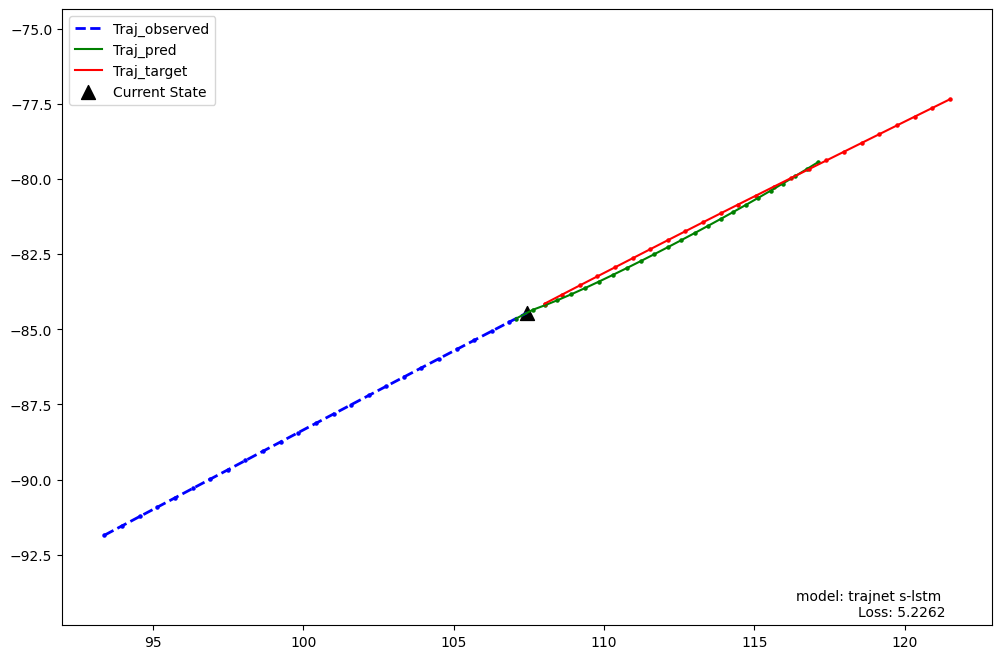

torch.Size([50, 12, 4])


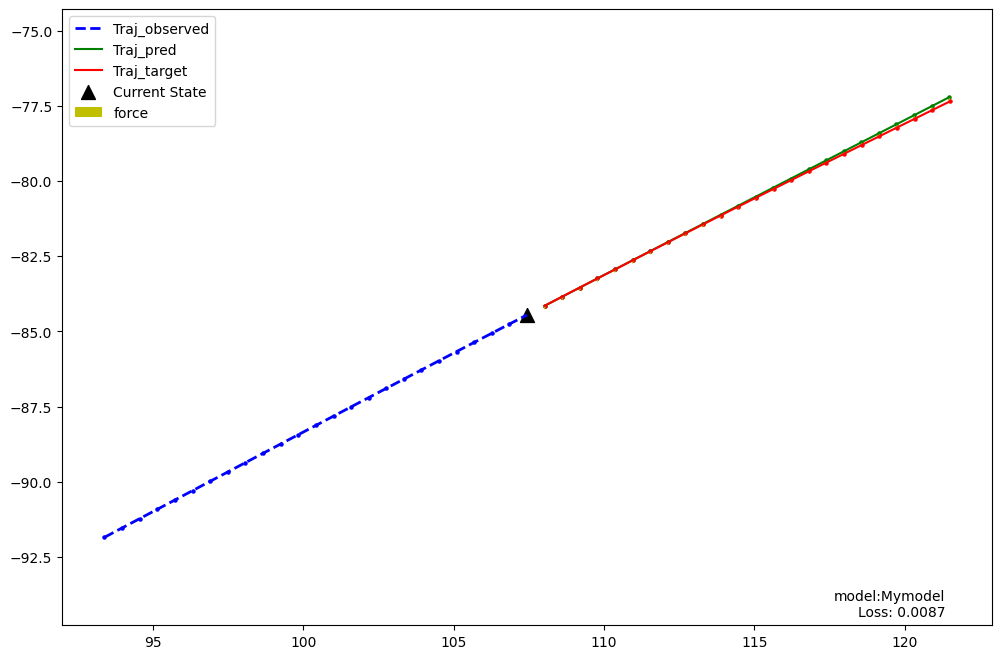

In [49]:
Traj_plot1(800, test_scenes, train_scale, model1, criterion, device)
Traj_plot2(800, test_scenes, train_scale, model2, criterion, device)
#800, 900, 1800, 3200

In [50]:
Traj_plot_classical(800, test_scenes, 'all', average_l2)#350

AttributeError: 'str' object has no attribute 'frame'

In [53]:
def parse_and_plot_log(log_filename):
    # Read the log file
    with open(log_filename, "r") as file:
        log_contents = file.readlines()

    # Extract train and eval loss from the log
    train_losses = []
    eval_losses = []

    for line in log_contents:
        data = json.loads(line)
        if data['type'] == 'train-epoch':
            train_losses.append(data['loss'])
        elif data['type'] == 'val-epoch':
            eval_losses.append(data['loss'])

    # Plotting the train and eval loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Train Loss", color="blue")
    plt.plot(eval_losses, label="Eval Loss", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train/Eval Loss over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Return the last eval loss
    return eval_losses[-1]


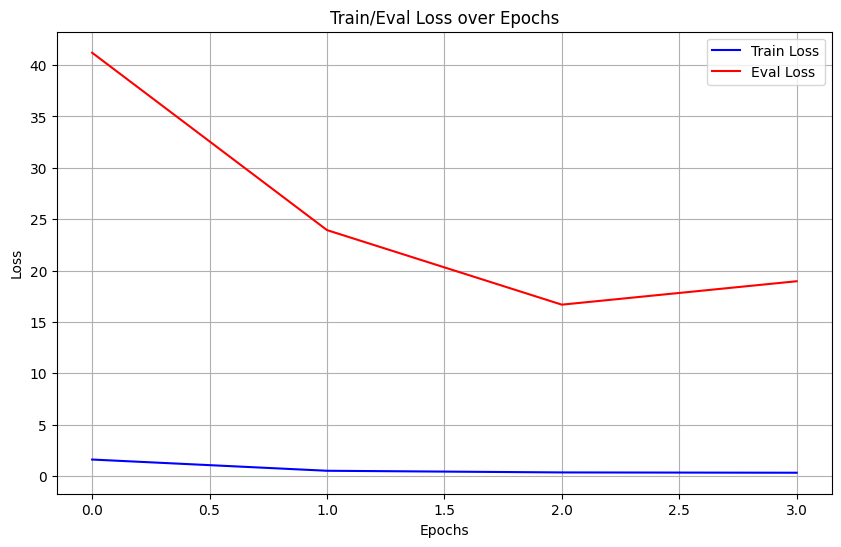

18.965

In [54]:
parse_and_plot_log('OUTPUT_BLOCK/ind2/lstm_vanilla_None.log')


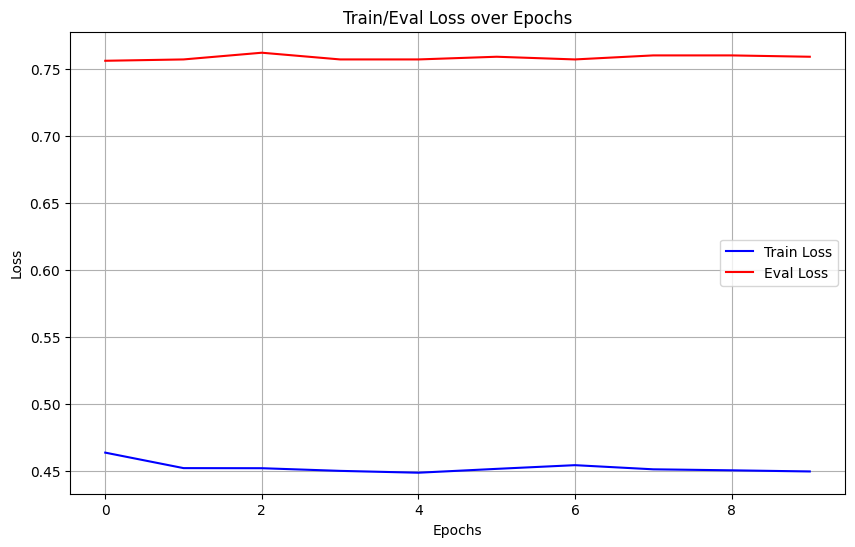

0.759

In [55]:
parse_and_plot_log('OUTPUT_BLOCK/ind1/lstm_vanilla_None.log')